In [2]:
import radd
from radd import build, vis
import warnings
warnings.filterwarnings("ignore")

# may take a while to build font cache
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import radd
from radd import build, vis

# Dependent Process (SS Race) Model

In [4]:
# Initial state of Stop process (red) depends on current strength of 
# Go activation (green) assumes Stop signal efficacy at later SSDs diminishes 
# as the state of the Go process approaches the execution threshold (upper bound). 
# (pink lines denote t=SSD, blue is trial deadline)
radd.load_dpm_animation()

In [5]:
# read data into pandas DataFrame (http://pandas.pydata.org/)
# example_data contains data from 15 subjects in the 
# Reactive Stop-Signal task discussed in Dunovan et al., (2015)
data = radd.load_example_data()
data.head()

,idx,Cond,ttype,choice,response,acc,rt,ssd
0,28,bsl,go,go,1,1,0.5985,1000
1,28,bsl,go,go,1,1,0.5202,1000
2,28,bsl,go,go,1,1,0.5451,1000
3,28,bsl,go,go,1,1,0.5716,1000
4,28,bsl,go,go,1,1,0.5052,1000


# Formatting data for radd
## Required columns
* **idx**: Subject ID number
* **ttype**: Trial-Type ('go' if no stop-signal, 'stop' if stop-signal trial)
* **response**: Trial Response (1 if response recorded, 0 if no response)
* **acc**: Choice Accuracy (1 if correct, 0 if error)
* **rt**: Choice Response-Time (in seconds, can be any value no-response trials)
* **ssd**: Stop-Signal Delay (in milliseconds, 1000 on go trials)

## Optional columns
* input dataframe can contain columns for experimental conditions of interest (choose any name)
* in the dataframe above, the **Cond** column contains **'bsl'** and **'pnl'**  
    * in the **'bsl'** or **"Baseline"** condition, errors on **go** and **stop** trials are equally penalized 
    * in the  **'pnl'** or **"Caution"** condition, penalties are doubled for **stop** trial errors  (e.g., response=1)
* See below for fitting models with conditional parameter dependencies 
    * e.g., drift-rate depends on levels of 'Cond'

# Building a model

In [6]:
model = build.Model(data=data, kind='xdpm', depends_on={'v':'Cond'})
model.observedDF.head()

,idx,Cond,acc,200,250,300,350,400,c10,c20,...,c90,e10,e20,e30,e40,e50,e60,e70,e80,e90
0,28,bsl,0.9917,1.0,1.0,0.95,0.60,0.00,0.5051,0.5252,...,0.5982,0.4961,0.5185,0.5317,0.5318,0.5319,0.5449,0.5458,0.5584,0.5674
1,28,pnl,0.9752,1.0,1.0,0.95,0.80,0.10,0.5177,0.5318,...,0.6119,0.5198,0.5324,0.5452,0.5542,0.5586,0.5638,0.5718,0.5851,0.6021
2,29,bsl,0.9917,1.0,1.0,1.00,0.90,0.00,0.5250,0.5377,...,0.5984,0.5268,0.5450,0.5451,0.5489,0.5585,0.5585,0.5709,0.5848,0.5902
3,29,pnl,0.9669,1.0,1.0,1.00,0.75,0.35,0.5314,0.5452,...,0.6250,0.5314,0.5322,0.5448,0.5450,0.5517,0.5629,0.5751,0.5851,0.5980
4,30,bsl,0.9421,1.0,1.0,1.00,0.80,0.25,0.5298,0.5585,...,0.6384,0.5361,0.5452,0.5606,0.5842,0.5854,0.5985,0.6098,0.6118,0.6208


## Header of observed dataframe (model.observedDF)
* **idx**: subject ID
* **Cond**: Baseline(bsl)/Caution(pnl) (could be any experimental condition of interest) 
* **Acc**: Accuracy on "go" trials
* **sacc**: Mean accuracy on "stop" trials (mean condition SSD used during simulations)
* **c10 - c90**: 10th - 90th RT quantiles for correct responses
* **e10 - e90**: 10th - 90th RT quantiles for error responses

# Bounded Global & Local Optimization

## Global Optimization (Basinhopping w/ bounds)
tams()** method gives control over low-level parameters used for global opt
* **xtol = ftol = tol**: error tolerance of global optimization (default=1e-20)

* **stepsize** (default=.05): set basinhopping initial step-size
    * see HopStep class in radd.fit for more details
    * see get_stepsize_scalars() in radd.theta for parameter-specific step-sizes

* **nsamples** (default=3000): number of parameter subsets to sample
 * number of individual parameter subsets $\theta_i \in \Theta$ to sample and evaluate before initializing global opt
    
$$\Theta = \{\theta_1, \theta_2 \dots \theta_{nsamples}\}$$
    
 * For each sampled parameter subset $\theta_i = \{a_G, v_G, tr_G, \dots\, v_S\}$ (see table below for description of parameters), the vector of observed data  $Y$ (accuracy and correct & error RT quantiles) is compared to an equal length vector of model-predicted data $f(\theta_i)$ via the weighted cost function:
   
$$\chi^2(\theta_i) = \sum  \omega * [ Y - f(\theta_i) ]^2$$
   
 * The parameter set (or *sets* - see **ninits** below) that yield the lowest cost function error ($\chi^2(\theta_i)$) are then used to initialize the model for global optimization ($\theta_{init}$)
   
$$\theta_{init} = \operatorname*{argmin}_{\theta}\chi^2(\theta_i)$$ 


| $$\theta$$ | Description     | str id | Go/Stop |
|:----------:|:----------------|:------:|:-------:|
| $$a_{G}$$  | Threshold       |  'a'   | Go      |
| $$tr_{G}$$ | Onset-Delay     |  'tr'  | Go      |
| $$v_{G}$$  | Drift-Rate      |  'v'   | Go      |  
| $$xb_{G}$$ | Dynamic Gain    |  'xb'  | Go      |
| $$v_{S}$$  | SS Drift-Rate   |  'ssv' | Stop    |
| $$so_{S}$$ | SS Onset-Delay  |  'sso' | Stop    |


* **ninits** (default=3): number of initial parameter sets to perform global optimization on

    * if ninits is 1 global optimization is performed once, using sampled parameter set with the lowest cost error (as described above in **nsamples**)

    * if ninits is greater than 1 then global optimization is performed $n$ separate times, one for each each $p_{i} \in P_{inits}$ where $P_{inits}$ is the rank ordered set of parameters subsets corresponding to $n-{th}$ lowest cost error
    
    * The optimized parameters corresponding to the lowest global minimum across all iterations of basinhopping are then selected and passed to the next stage in the fitting routine (local gradient-based optimization)

* **nsuccess** (default=60): criterion number of successful steps without finding new global minimum to exit basinhopping

* **interval** (default=10): number of steps before adaptively updating the stepsize 

* **T** (default=1.0): set the basinhopping "temperature"
    * higher T will result in accepted steps with larger changes in function value (larger changes in model error)
    
### Using set_basinparams() to control global opt. params
```python
model.set_basinparams(tol=1e-15, nsamples=4000, ninits=6, nsuccess=70)
```

# Sampling Distributions for Init Parameters

No handles with labels found to put in legend.


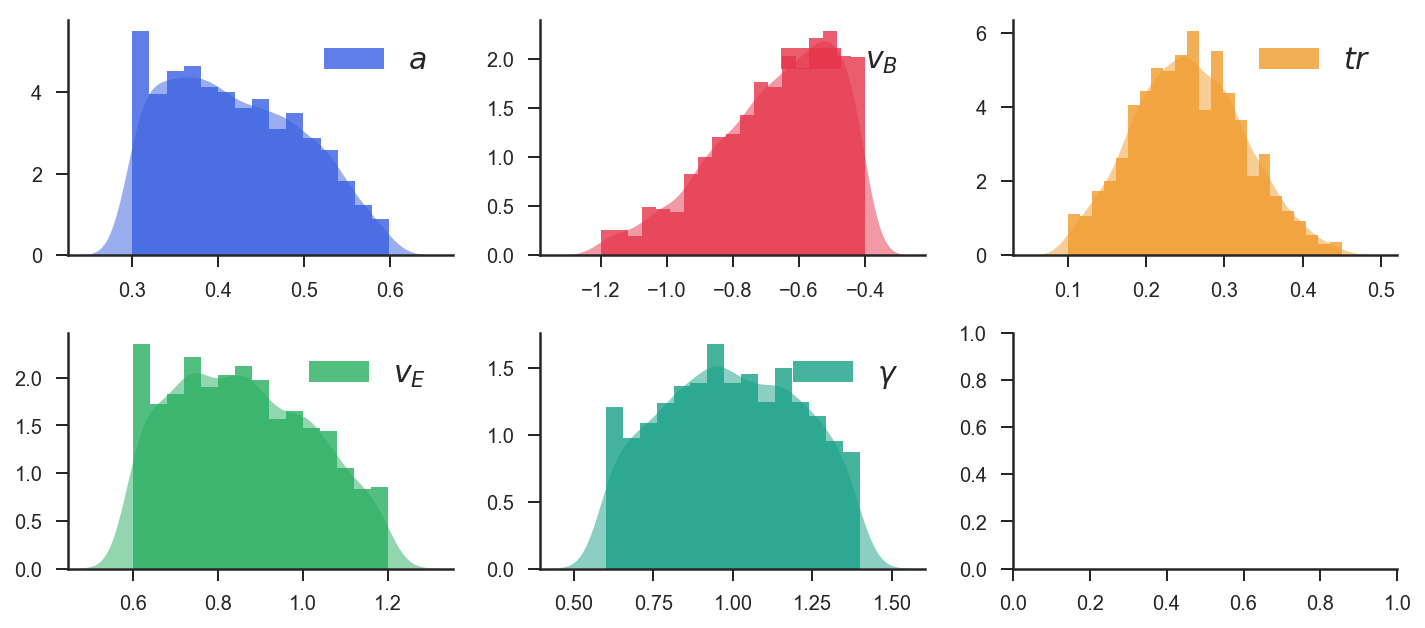

In [7]:
# sample model.basinparams['nsamples'] from each dist (default=3000)
# and initialize model with best model.basinparams['ninits'] (default=3)
vis.plot_param_distributions(p=model.inits)

## Local Optimization (Nelder-Mead Simplex w/ bounds)
* **set_fitparams()** method gives control over low-level parameters used for local opt. Local optimization polishes parameter estimates passed from global optimization step.

 * **method** (default='nelder'): optimization algorithm 
     * (see [here](https://lmfit.github.io/lmfit-py/fitting.html#choosing-different-fitting-methods) for list of available methods)

 * **xtol = ftol = tol** (default=1e-30): error tolerance of optimization

 * **maxfev** (default=2000): max number of func evaluations to perform

 * **ntrials** (default=20000): num. simulated trials per condition

### Using set_fitparams() to control local optimization parameters

```python
model.set_fitparams(method='tnc', tol=1e-35, ntrials=30000, maxfev=2500)
```

### Using set_fitparams() to set/access low-level model attributes

* **set_fitparams()** also allows you to control low-level attributes of the model, including...

 * **quantiles** (default=np.array([.10, .20, ... .90]): quantiles of RT distribution

 * **kind** (default='dpm'): model kind (currently only irace and dpm) 

 * **depends_on** (dict): {parameter_id : condition_name}

 * **tb** (float): trial duration (timewindow for response) in seconds

 * **nlevels** (int): number of levels in depends_on data[condition_name]  

 * **fit_on (default='average')**: by default, models are fit to the 'average' 
    data (across subjects). If **fit_on='subjects'**, a model is fit to each individual 
    subject's data.
    
```python
q = np.arange(.1, 1.,.05)
model.set_fitparams(kind='irace', depends_on={'a': 'Cond'}, quantiles=q)
```

# Fitting Flat Models
- All models are initially fit by optimizing the full set of parameters to the "flattened" data (flat meaning the average data collapsing across all conditions of interest). 

### Steps in fitting routine: 

1. Global optimzation on flat data (average values collapsing across any/all conditions)
2. Local optimzation using parameters passed from global optimizer as starting values 


- Flat model fits are performed by identifying the full set of parameter values that minimize the following cost-function: 

    $$\chi^2 = \sum [\omega * (\hat{Y} - Y)]^2$$
  
- *$Y$* is an array of observed data (e.g., accuracy, RT quantiles, etc.) 
- *$\hat{Y}$* is an equal length array of corresponding model-predicted values, given by the parameterized model $f(\theta)$
- The error $\chi^2$ between the predicted and the observed data (**$\hat{Y} - Y$**) is weighted by an equal length array of scalars **$\omega$** proportional to the inverse of the variance in each value of **$Y$**. 

### Accessing flat weights ($\omega$)  and data ($Y$)  vectors 

```python
flat_data = model.observedDF.mean()
flat_wts = model.wtsDF.mean() 
```

# Model.optimize()
```python
Model.optimize(self, plotfits=True, saveplot=False, saveresults=True, saveobserved=False, custompath=None, progress=False):
    """ Method to be used for accessing fitting methods in Optimizer class
        see Optimizer method optimize()
    ::Arguments::
        plotfits (bool):
            if True (default), plot model predictions over observed data
        saveplot (bool):
            if True (default), save plots to "~/<self.model_id>/"
        saveresults (bool):
            if True (default), save fitdf, yhatdf, and txt logs to "~/<self.model_id>/"
        saveobserved (bool):
            if True (default is False), save observedDF to "~/<self.model_id>/"
        custompath (str):
            path starting from any subdirectory of "~/" (e.g., home).
            all saved output will write to "~/<custompath>/<self.model_id>/"
        progress (bool):
            track progress across ninits and basinhopping
    """
```

### saving model output
* By default the model creates a folder named after the model's model_id attribute in your user home directory (model_id is string with identifying information about the model) and saves all model output to this location (saveresults=True).

* To prevent the model from creating the output directory

```python
m = build.Model(data=data)
m.optimize(saveresults=False)
```

* Or to customize the location of the output directory

```python
# note, custompath must be an existing path to the parentdirectory 
# where you want the model's output directory to be created
# save model output to /Users/kyle/Dropbox/<model_id>/
m.optimize(custompath='Dropbox')
```

* You can also opt to save the model's observedDF: a pandas dataframe containing all subject's stop accuracy & RT quantile data

```python
# save model output and observed data to /Users/kyle/Dropbox/<model_id>/
m.optimize(custompath='Dropbox', saveobserved=True)
```


### generating and saving plots
* By default (plotfits=True), the optimize function plots the model-predicted stop accuracy and correct/error RT quantiles over the observed data. 
* You can opt to save the plot in the model's output directory by setting saveplot to True (defaults to False)

```python
# save fit plot to /Users/kyle/Dropbox/<model_id>/
m.optimize(custompath='Dropbox', saveplot=True)
```

### progress bars

* when optimizing a model, you can get feedback about the global optimization process by setting progress to True

```python
model.optimize(progress=True)
```

* The green bar tracks the initial parameter sets (current set / ninits). 
* The red bar gives feedback about the basinhopping run (current-step / global-minimum).
  * If the global minimum stays the same for "nsuccess" steps, global optimization is terminated for the current init set and the green bar advances (meaning a new round of global optimization has begun with the model initialized with the next init parameter set).
  * If a new global minimum is found, the red bar resets and the nsuccess count begins again from 0.

IntProgress(value=0, max=2)

IntProgress(value=0, bar_style='danger', max=50)

IntProgress(value=0, bar_style='success', max=1000)

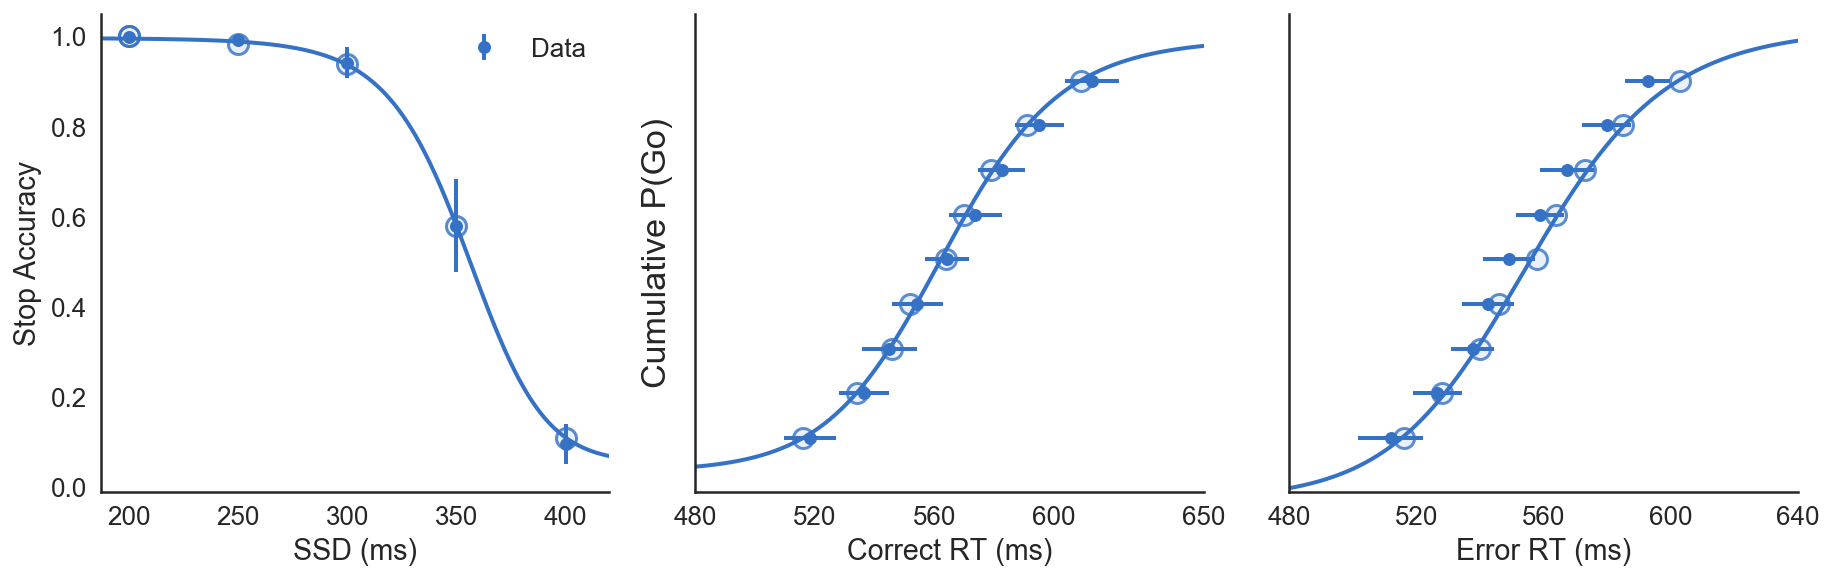

In [129]:
# build a model with no conditional dependencies (a "flat" model)
model = build.Model(data=data, kind='xdpm')
model.set_basinparams(method='basin', nsamples=1000)

# NOTE: fits in the binder demo will be much slower than when run locally
# set_testing_params() sets more liberal fit criteria to speed things up a bit
# comment this line out to run fits using the default optimization criteria
model.set_testing_params()

model.optimize(progress=True, plotfits=True)

# Accessing model fit information

### Parameter estimates
* optimized parameter estimates are stored in the **poptdf** attribute

```python
# display the model's poptdf
model.poptdf
```

### Goodness-Of-Fit (GOF) stats
* critical information about the model fit is contained in the models **fitdf** attribute (pandas DataFrame). 
* **fitdf** includes optimized parameter estimates as well as goodness-of-fit (GOF) statistics like AIC, BIC, standard (chi) and reduced (rchi) chi-square

```python
# display the model's fitdf
model.fitdf
```

### model predictions
* optimize also generates a **yhatdf** attribute, a pandas DataFrame containing the model-predicted stop-accuracy and correct/error RT quantiles (same column structure as model's observedDF)

```python
# display the model's yhatdf
model.yhatdf
```

### save results post-optimization

* if you set saveresults to False when running optimize and later decide to save output dataframes

```python
# to save output dataframes
model.poptdf.to_csv("path/to/save/poptdf.csv", index=False)
model.fitdf.to_csv("path/to/save/fitdf.csv", index=False)
model.yhatdf.to_csv("path/to/save/yhatdf.csv", index=False)
```

In [130]:
model.fitdf

,idx,pvary,nvary,AIC,BIC,nfev,df,ndata,chi,rchi,logp,cnvrg,niter
0,avg,all,5.0,-237.8321,-231.9419,1006.0,19.0,24.0,0.0008,4.1380e-05,-247.8321,False,164.0


In [131]:
model.poptdf

,idx,flat,pvary,a,ssv,tr,v,xb
0,avg,flat,all,0.3655,-0.5514,0.2497,1.1222,0.8962


In [132]:
model.yhatdf

,idx,flat,pvary,acc,200,250,300,350,400,c10,...,c90,e10,e20,e30,e40,e50,e60,e70,e80,e90
0,avg,flat,all,0.9762,1.0,0.982,0.938,0.58,0.11,0.516,...,0.609,0.516,0.528,0.54,0.546,0.558,0.564,0.573,0.585,0.603


# Fitting Conditional Models

- Conditional models can be fit in which all parameters from **flat** model fit are held constant except for one or more designated **conditional** parameters which is free to vary across levels of an experimental condition of interest. 

### Steps in fitting routine: 

1. Global optimzation on flat data (average values collapsing across experimental conditions)
2. Local optimzation using parameters passed from global optimizer as starting values 
3. Global optimzation of conditional parameters 
4. Local optimzation of conditional parameters passed from global optimizer


- Conditional model fits are performed by holding all parameters constant except one or more **conditional** parameter(s) and minimizing following cost-function: 

$$\chi^2 = \sum_{i=0}^{N_c} [\omega_i * (\hat{Y_i} - Y_i)]^2$$
    
- where $\sum[\omega_i*(\hat{Y_i} - Y_i)]^2$ gives the cost ($\chi^2$) for level $i$ of condition $C$
- $\chi^2$ is equal to the summed and squared error across all $N_c$ levels of that condition

- Specifying parameter dependencies is done by providing the model with a **depends_on** dictionary when initializing the model with the format: **{parameter_id : condition_name}**.
- For instance, in Dunovan et al., (2015) subjects performed two versions of a stop-signal task 
     * **Baseline ("bsl")** condition: errors on **go** and **stop** trials are equally penalized 
     * **Caution ("pnl")** condition: penalties 2x higher for **stop** trial errors (e.g., response=1)
- To test the hypothesis that observed behavioral differences between penalty conditions was a result of a change Go drift-rate...

``` py
# define the model allowing Go drift-rate to vary across 'Cond'
model_v = build.Model(kind='xdpm', depends_on={'v': 'Cond'})
# run optimize to fit the full model (steps 1 & 2)
model_v.optimize(progress=True)
```


### Typically...

* ...you'll have multiple alternative hypotheses about which parameters will depend on various task conditions

* For instance, instead of modulating the Go drift-rate, assymetric stop/go penalties might alter behavior by changing the height of the decision threshold **(a)**. 

* To implement this model:

``` py
# define the model allowing threshold to vary across 'Cond'
model_a = build.Model(kind='xdpm', depends_on={'a': 'Cond'})
# run optimize to fit the full model (steps 1 & 2)
model_a.optimize(progress=True)
```

### compare model fits

* To test the hypothesis: threshold (a) better than drift-rate (v)

```python
# If True, threshold model provides a better fit
model_a.finfo['AIC'] < model_v.finfo['AIC']
```

### How to access conditional weights ($\omega_i$) and data ($Y_i$) vectors
```python
# replace 'Cond' with whatever your condition is called in the input dataframe
cond_data = model.observedDF.groupby('Cond').mean()
cond_wts = model.wtsDF.groupby('Cond').mean() 
```

IntProgress(value=0, max=2)

IntProgress(value=0, bar_style='danger', max=50)

IntProgress(value=0, bar_style='success', max=1000)

IntProgress(value=0, bar_style='success', max=300)

IntProgress(value=0, bar_style='success', max=1000)

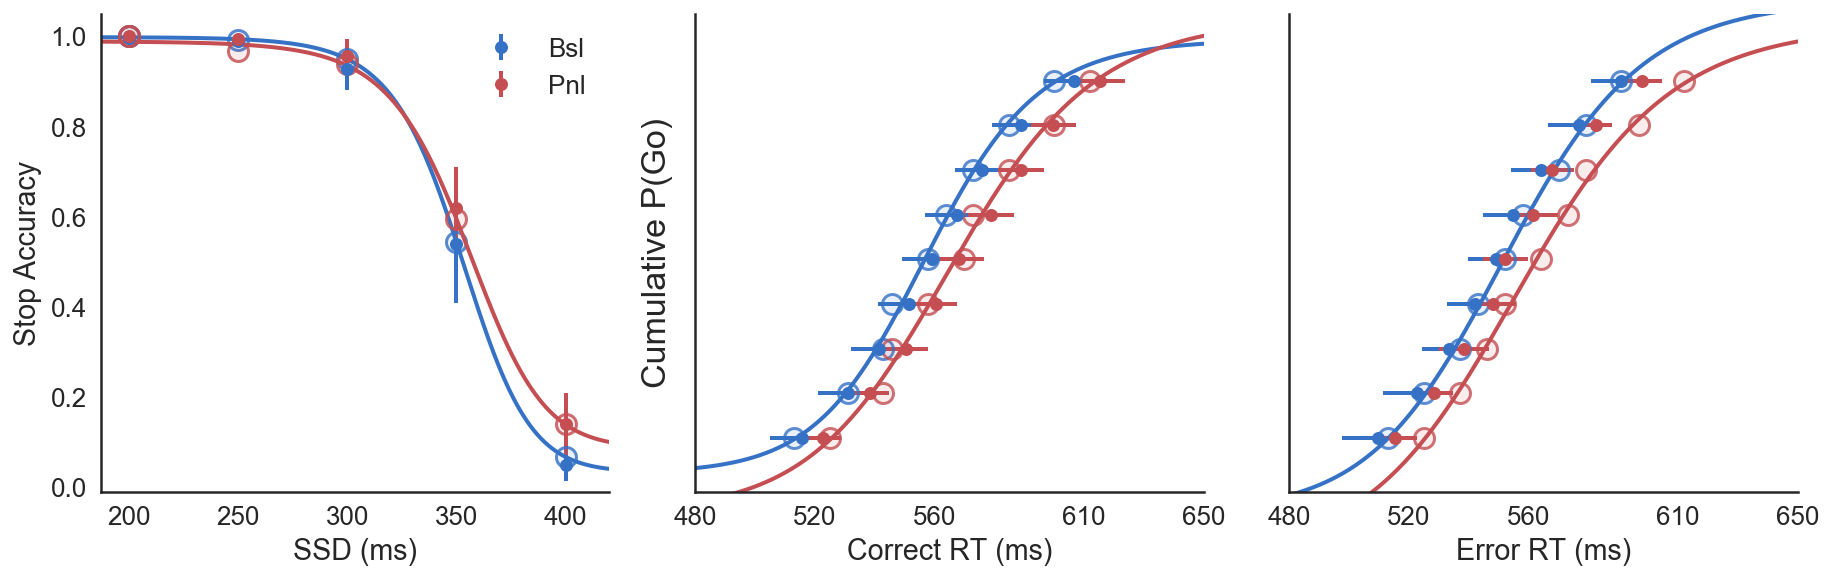

In [133]:
# build conditional model and optimize with drift-rate free across levels of Cond
model = build.Model(data=data, kind='xdpm', depends_on={'v':'Cond'})
model.set_basinparams(method='basin', nsamples=1000)

# NOTE: fits in the binder demo will be much slower than when run locally
# uncomment line below to speed up the demo fits (at the expense of fit quality)
model.set_testing_params()

model.optimize(progress=True, plotfits=True)

In [135]:
model.poptdf

,idx,Cond,pvary,a,ssv,tr,v,xb
0,avg,bsl,v,0.3619,-0.493,0.2571,1.0962,1.3999
1,avg,pnl,v,0.3619,-0.493,0.2571,1.0494,1.3999


# Nested optimization of alternative models

* Typically you'll have multiple competing hypotheses about which parameters are influenced by various task conditions

* Nested optimization allows alternative models to be optimized using a single initial parameter set.

```python 
model = build.Model(kind='xdpm', data=data)
freeparams = ['v', 'a', 'tr']
depends = [{pname: 'Cond'} for pname in freeparams] 
model.nested_optimize(depends=depends)
```

* After fitting the model with **depends_on={'v': 'Cond'}**, **'v'** is replaced by the next parameter in the **nested_models** list **('a' or boundary height in this case)** and the model is optimized with this dependency using the same init params as the original model

* As a result, model selection is less likely to be biased by the initial parameter set

* Also, because Step 1 takes significantly longer than Step 2, nested optimization of multiple models is significantly faster than optimizing each model individually through boths steps

In [203]:
model = build.Model(kind='xdpm', data=data)
model.set_basinparams(method='basin')#, nsamples=1000)

# NOTE: fits in the binder demo will be much slower than when run locally
# uncomment line below to speed up the demo fits (at the expense of fit quality)
# model.set_testing_params()

freeparams = ['v', 'a', 'tr']
depends = [{pname: 'Cond'} for pname in freeparams]
fitdf, poptdf, yhatdf = model.nested_optimize(depends=depends, progress=True, plotfits=False)

IntProgress(value=0, max=3)

IntProgress(value=0, bar_style='success', max=300)

IntProgress(value=0, bar_style='success', max=1000)

IntProgress(value=0, max=3)

IntProgress(value=0, bar_style='success', max=300)

IntProgress(value=0, bar_style='success', max=1000)

IntProgress(value=0, max=3)

IntProgress(value=0, bar_style='success', max=300)

IntProgress(value=0, bar_style='success', max=1000)

# Examine Nested Model Fits

In [204]:
# compare GOF stats for the three models
fitdf

,modelID,idx,pvary,nvary,AIC,BIC,nfev,df,ndata,chi,rchi,logp,cnvrg,niter
0,v,avg,v,2.0,-450.1397,-446.3973,340.0,46.0,48.0,0.0037,8.1193e-05,-454.1397,True,3.0
1,a,avg,a,2.0,-416.4137,-412.6713,275.0,46.0,48.0,0.0075,1.6393e-04,-420.4137,True,3.0
2,tr,avg,tr,2.0,-423.6146,-419.8722,206.0,46.0,48.0,0.0065,1.4109e-04,-427.6146,True,2.0


In [205]:
# Model Predictions (same header as model.observedDF)
yhatdf

,modelID,idx,Cond,pvary,acc,200,250,300,350,400,...,c90,e10,e20,e30,e40,e50,e60,e70,e80,e90
0,v,avg,bsl,v,0.9826,1.0,0.973,0.940,0.537,0.069,...,0.606,0.498,0.516,0.528,0.540,0.543,0.555,0.567,0.579,0.594
1,v,avg,pnl,v,0.9592,1.0,0.963,0.947,0.616,0.145,...,0.618,0.510,0.528,0.534,0.543,0.555,0.561,0.573,0.591,0.606
2,a,avg,bsl,a,0.9832,1.0,0.990,0.956,0.555,0.096,...,0.600,0.498,0.510,0.522,0.534,0.537,0.549,0.561,0.573,0.591
3,a,avg,pnl,a,0.9569,1.0,0.958,0.938,0.617,0.135,...,0.618,0.516,0.528,0.540,0.549,0.555,0.567,0.579,0.588,0.606
4,tr,avg,bsl,tr,0.9733,1.0,0.978,0.936,0.505,0.070,...,0.606,0.498,0.516,0.528,0.537,0.543,0.555,0.567,0.579,0.600
5,tr,avg,pnl,tr,0.9650,1.0,0.966,0.951,0.665,0.127,...,0.612,0.504,0.528,0.540,0.546,0.555,0.567,0.579,0.591,0.606


AIC likes v model
BIC likes v model


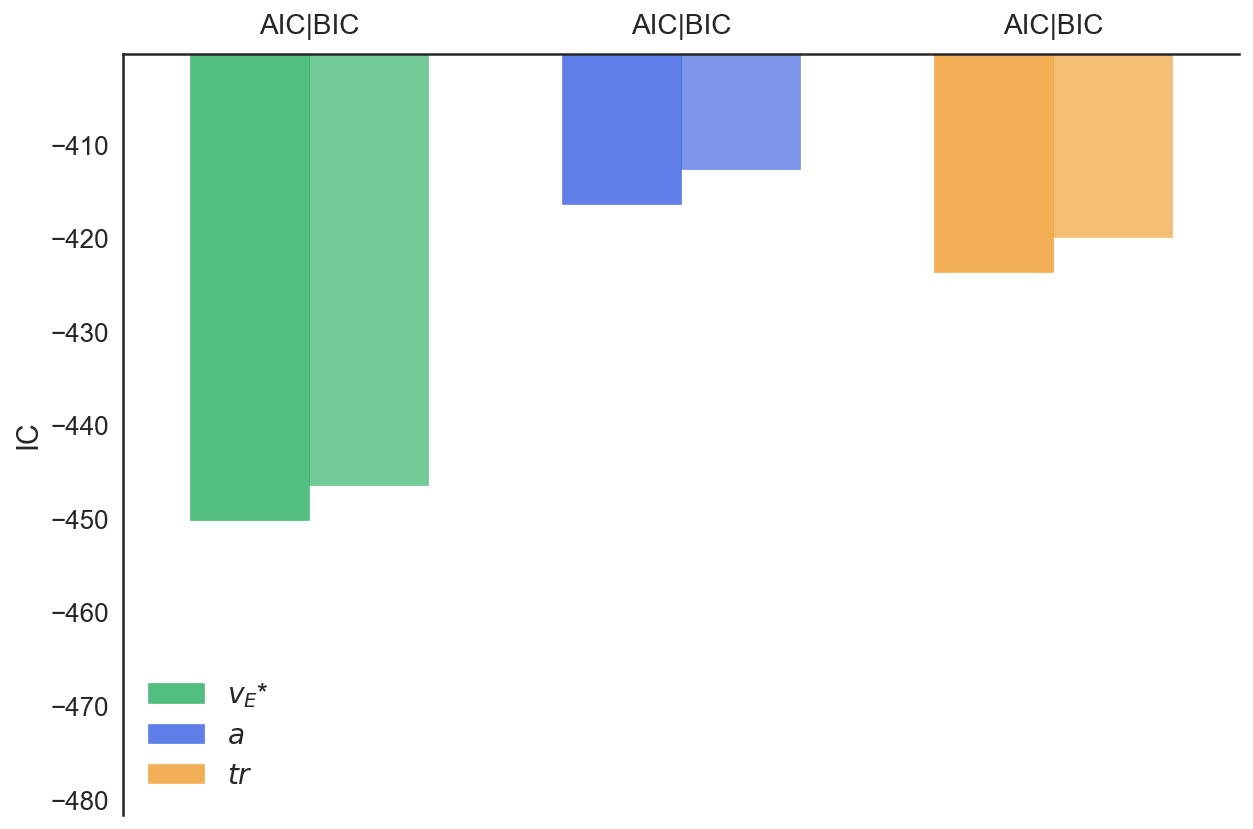

In [206]:
# Evaluate all nested fits and plot fit stats: AIC & BIC (Lower is better)
# According to AIC & BIC, the model with execution drift-rate (v_E) free across levels of Cond 
# provides a better fit than models with free threshold (a) or onset delay (tr)
gof = vis.compare_nested_models(fitdf, verbose=True, model_ids=nested_models)

#  Testing model identity (parameter recovery)
* **recover_model()** samples a large number of parameter sets and chooses one that yields a synthetic data vector close to the actual observed data vectors in **model.observed_flat** & **model.observed**
* the model then goes through the fitting routine, optimizing an independent set of parameters to the synthetic data
* when the model is finished optimizing, the recovered parameters are compared and plotted against the generative set of parameters. 
* if the values are close, this is evidence that the model is identifiable 

In [ ]:
# build a model and sample parameters
model = build.Model(data=data, kind='xdpm', depends_on={'v':'Cond'})
# fit synthetic data and compare fitted vs. init params
model.recover_model(progress=True, plotparams=True)

# Troubleshooting Ugly Fits

## Fit to individual subjects
```python
model = build.Model(data=data, fit_on='subjects')
```
## Other "kinds" of models...


* Currently only Dependent Process Model **(kind='dpm')** and Independent Race Model **(kind='irace')**


* Tell model to include a Dynamic Bias Signal **('xb')** by adding an **'x'** to the front of model **kind**


* To implement the **Dependent Process Model**...

```python
#... with dynamic bias: 
model = build.Model(data=data, kind='xdpm')
#...and without: 
model = build.Model(data=data, kind='dpm')
```


* To implement the **Independent Race Model**... 


```python
#... with dynamic bias:
model = build.Model(data=data, kind='xirace')
#... and without:
model = build.Model(data=data, kind='irace')
```



## Optimization parameters and cost weights...

* set more conservative fit criteria

```python
model.set_basinparams(nsuccess=100, tol=1e-30, ninits=10, nsamples=10000) 
model.set_fitparams(maxfev=5000, tol=1e-35)
```

* Inspect cost function weights for extreme vals

```python
print(model.cond_wts)
print(model.flat_wts)
```
* If the wts look suspect try re-running the fits with an unweighted model (all wts = 1)     


```python
 model = build.Model(data=data, weighted=False)
```

* Keep in mind that error RTs can be particularly troublesome, sometimes un-shootably so...

In [207]:
import radd
radd.style_notebook()